<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_7_Pro_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BA%D1%86%D0%B8%D0%B9_%D0%9B%D1%83%D0%BA%D0%BE%D0%B9%D0%BBipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRO задание. Вариант 1
База Лукойл
Сделайте сложную сеть с предсказанием на один шаг и valLen = 30000 из LSTM, Conv1D и/или Dense слоёв, так, чтобы корреляция на старте была 99,9% и строго убывала

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import figure
%matplotlib inline

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv1D, LSTM, GlobalMaxPooling1D, MaxPooling1D, LocallyConnected1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, Nadam

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import utils
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики

In [3]:
#Формируем параметры загрузки данных
xLen = 300      #Анализируем по 300 прошедшим точкам 
valLen = 30000  #Используем 30.000 записей для проверки 
batch_size=20   #Размер batch, который будем скармливать модели #хороший результат при 20
target = 3      # 'CLOSE'

## Загружаем данные

In [33]:
#Считываем данные
import os
os.chdir('/content/drive/My Drive/Занятие_7_Временные ряды/data/акции лукойл/')
base_data18_19 = pd.read_csv('18_19.csv', sep=';')
base_data16_17 = pd.read_csv('16_17.csv', sep=';')
base_data16_17[:3]

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257


In [32]:
data16_17 = base_data16_17.iloc[:,2:]
data18_19 = base_data18_19.iloc[:,2:]
print(data16_17.index)
print(data18_19.index, '\n')

RangeIndex(start=0, stop=263925, step=1)
RangeIndex(start=0, stop=217947, step=1) 



In [31]:
df = pd.concat([data16_17, data18_19])
print(df.iloc[0], '\n')
data = np.array(df) # Превратили в массив numpy
data.shape

OPEN      2351.0
MAX       2355.8
MIN       2350.0
CLOSE     2350.0
VOLUME    2547.0
Name: 0, dtype: float64 



(481872, 5)

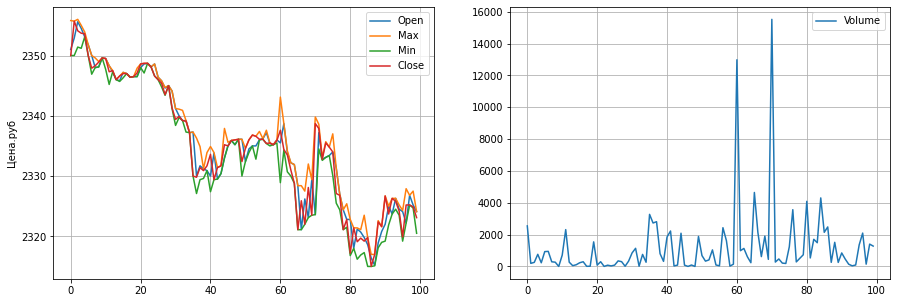

In [12]:
plt.figure(figsize=(15, 5))

start = 0       
stop = 100 
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

plt.subplot(1,2,1)
for i in range(4):
  plt.plot(data[start:start+stop, i], label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.grid()
plt.show()

## Подготовка данных

In [13]:
# Цикл для прогноза изпенений цены CLOSE (разности текущее - предыдущее)
#ddata = np.zeros((len(data), 1))
#for i in range(1, len(data)):
#    ddata[i] = data[i, target] - data[i - 1, target] # приращения (текущее - предыдущее)
    # в этом сеть должна предсказывать не следущее значение, а на сколько изменится текущее значение в следующий момент
#ddata[0] = 0.

In [14]:
trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]
print('xTrain: ', xTrain.shape, 'xTest:', xTest.shape)
xScaler = MinMaxScaler() #Масштабируем X чтобы их легче было скормить сетке
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению Close
yTrain, yTest = data[:trainLen, target], data[trainLen+xLen+2:, target]
print('yTrain: ', yTrain.shape, 'yTest:', yTest.shape)
yTrain, yTest = np.reshape(data[:trainLen, target],(-1,1)), np.reshape(data[trainLen+xLen+2:, target],(-1,1))
yScaler = MinMaxScaler() #Масштабируем Y чтобы их легче было скормить сетке
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)
print('yTrain: ', yTrain.shape, 'yTest:', yTest.shape)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,       
                    length = xLen,      # Длина выходных последовательностей (по количеству временных интервалов)
                    stride = 1,         # Период между последовательными выходными последовательностями
                    sampling_rate = 1,  # Период между последовательными отдельными временными шагами внутри последовательностей
                    batch_size = batch_size)                

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                     length = xLen, stride = 1,
                     batch_size = batch_size)

print('\nlen(trainDataGen) = ', len(trainDataGen), 'len(testDataGen) = ', len(testDataGen))

xTrain:  (451872, 5) xTest: (29698, 5)
yTrain:  (451872,) yTest: (29698,)
yTrain:  (451872, 1) yTest: (29698, 1)

len(trainDataGen) =  22579 len(testDataGen) =  1470


In [15]:
print('yTrain:', yTrain[0], '\nxtrain:', xTrain[0])
print('\nРазмерности после TimeseriesGenerator (X)(Y): ', trainDataGen[0][0].shape, trainDataGen[0][1].shape)

yTrain: [0.07810564] 
xtrain: [0.07839171 0.07822035 0.07839814 0.07810564 0.00059283]

Размерности после TimeseriesGenerator (X)(Y):  (20, 300, 5) (20, 1)


## Функции визуализации результатов

In [16]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.grid()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.grid()
  plt.show()

In [17]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Создаем нейросеть

### Bidirectional LSTM (2) - нужно мало эпох, но каждая по часу и больше )

---



In [25]:
input = Input(shape = (xLen, 5))
x = Bidirectional(LSTM(2))(input)
#x = LSTM(50)(x)
x = Dense(10, activation='linear')(x)
x = Dense(1, activation='linear')(x)
modelL = Model(input, x)

#plot_model(modelL, dpi=60, show_shapes=True, show_layer_names=True)

Epoch 1/3
22579/22579 [==============================] - 2635s 117ms/step - loss: 3.1331e-04 - val_loss: 1.6476e-05
Epoch 2/3
22579/22579 [==============================] - 2671s 118ms/step - loss: 6.7726e-06 - val_loss: 4.6515e-06
Epoch 3/3
22579/22579 [==============================] - 2684s 119ms/step - loss: 3.1416e-06 - val_loss: 4.2104e-06


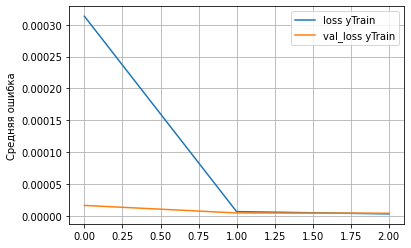

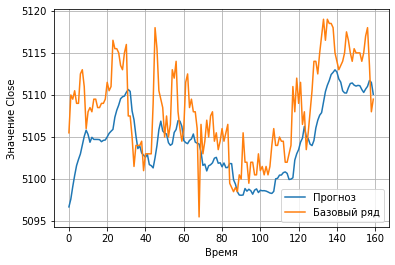

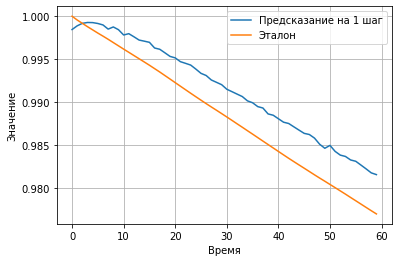

In [27]:
#Компилируем
modelL.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = modelL.fit_generator(trainDataGen, epochs=3, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])


#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = modelL #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

### LSTM (50-10) - лучшая!!!

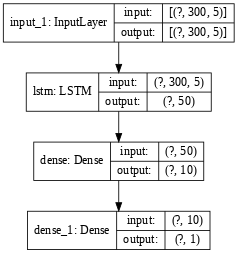

In [4]:
input = Input(shape = (xLen, 5))
x = LSTM(50)(input)
x = Dense(10, activation='linear')(x)
x = Dense(1, activation='linear')(x)
modelL = Model(input, x)

plot_model(modelL, dpi=60, show_shapes=True, show_layer_names=True)

Epoch 1/20
22579/22579 [==============================] - 292s 13ms/step - loss: 3.1105e-04 - val_loss: 2.9892e-06
Epoch 2/20
22579/22579 [==============================] - 292s 13ms/step - loss: 6.3376e-06 - val_loss: 1.3145e-06
Epoch 3/20
22579/22579 [==============================] - 292s 13ms/step - loss: 4.4027e-06 - val_loss: 1.1285e-06
Epoch 4/20
22579/22579 [==============================] - 293s 13ms/step - loss: 2.7569e-06 - val_loss: 1.0083e-06
Epoch 5/20
22579/22579 [==============================] - ETA: 0s - loss: 2.2908e-06
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
22579/22579 [==============================] - 294s 13ms/step - loss: 2.2908e-06 - val_loss: 8.8952e-07
Epoch 6/20
22579/22579 [==============================] - 291s 13ms/step - loss: 7.4147e-07 - val_loss: 8.3953e-07
Epoch 7/20
22579/22579 [==============================] - 290s 13ms/step - loss: 7.1914e-07 - val_loss: 1.2473e-06
Epoch 8/20
22578/22579 [================

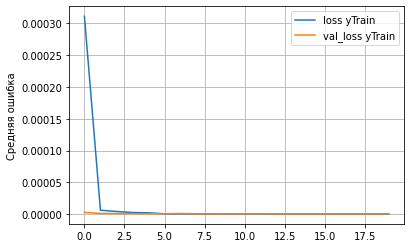

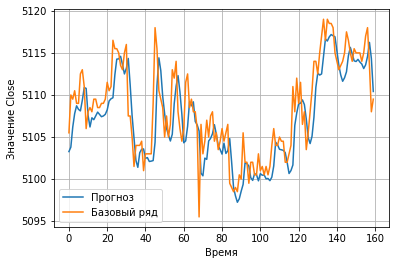

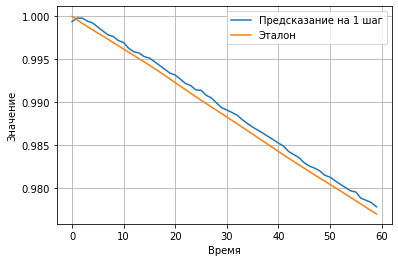

In [ ]:
#Компилируем
modelL.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = modelL.fit_generator(trainDataGen, epochs=20, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])


#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = modelL #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

### Concatenate RNN + LocallyConnected1D (CNN)

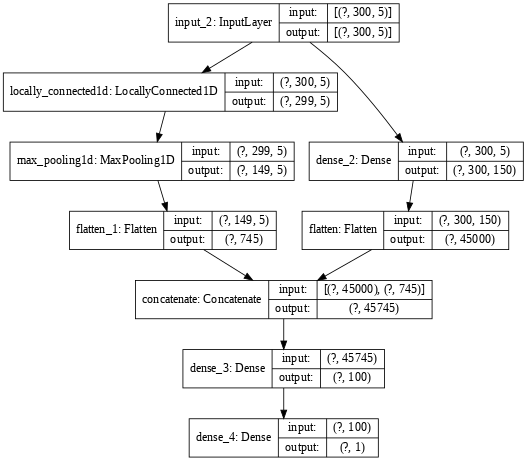

In [ ]:
input = Input(shape = (xLen, 5))

D = Dense(150, activation='linear')(input)
D = Flatten()(D)

C = LocallyConnected1D(5, 2, activation='relu')(input)
C = MaxPooling1D(pool_size=2)(C)
C = Flatten()(C)

x = concatenate([D, C])
x = Dense(100, activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

Epoch 1/50
22579/22579 [==============================] - 154s 7ms/step - loss: 0.1238 - val_loss: 3.2382e-05
Epoch 2/50
22579/22579 [==============================] - 155s 7ms/step - loss: 2.4466e-04 - val_loss: 0.0038
Epoch 3/50
22579/22579 [==============================] - 160s 7ms/step - loss: 5.8538e-05 - val_loss: 6.1706e-05
Epoch 4/50
22579/22579 [==============================] - 160s 7ms/step - loss: 3.2417e-05 - val_loss: 1.5846e-05
Epoch 5/50
22579/22579 [==============================] - 159s 7ms/step - loss: 2.4789e-05 - val_loss: 8.8490e-06
Epoch 6/50
22574/22579 [============================>.] - ETA: 0s - loss: 1.8801e-05
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
22579/22579 [==============================] - 160s 7ms/step - loss: 1.8802e-05 - val_loss: 1.7842e-04
Epoch 7/50
22579/22579 [==============================] - 159s 7ms/step - loss: 4.4516e-06 - val_loss: 1.0986e-05
Epoch 8/50
22579/22579 [==============================]

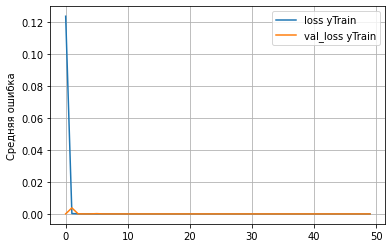

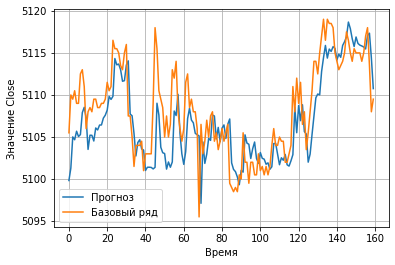

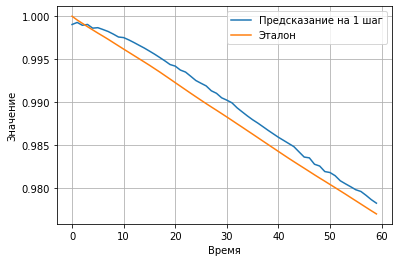

In [ ]:
#Компилируем
model.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = model.fit_generator(trainDataGen, epochs=50, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])


#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

### Concatenate RNN + CNN + LSTM(10-10) - лучшая!!!

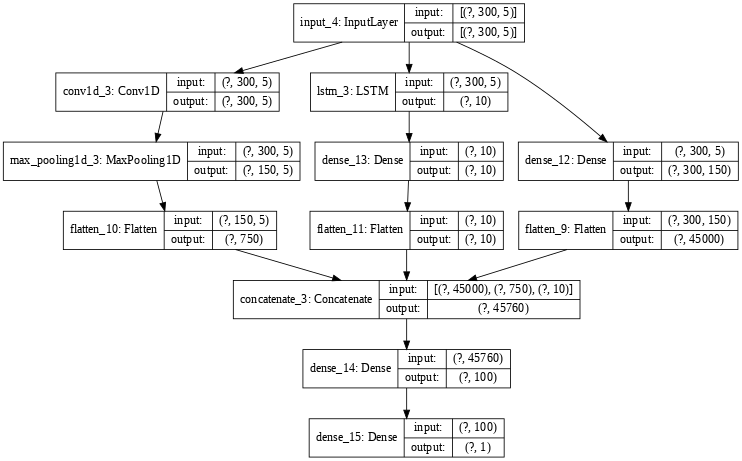

In [ ]:
input = Input(shape = (xLen, 5))

D = Dense(150, activation='linear')(input)
D = Flatten()(D)

C = Conv1D(5, 2, padding='same', activation='relu')(input)
C = MaxPooling1D(pool_size=2)(C)
C = Flatten()(C)

L = LSTM(10)(input)
L = Dense(10, activation='linear')(L)
L = Flatten()(L)

x = concatenate([D, C, L])
x = Dense(100, activation='linear')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

Epoch 1/50
22579/22579 [==============================] - 309s 14ms/step - loss: 0.0698 - val_loss: 0.0098
Epoch 2/50
22579/22579 [==============================] - 306s 14ms/step - loss: 2.1919e-04 - val_loss: 0.0020
Epoch 3/50
22579/22579 [==============================] - 309s 14ms/step - loss: 7.4345e-05 - val_loss: 1.4551e-05
Epoch 4/50
22579/22579 [==============================] - 321s 14ms/step - loss: 4.0305e-05 - val_loss: 2.1243e-05
Epoch 5/50
22579/22579 [==============================] - 322s 14ms/step - loss: 3.1606e-05 - val_loss: 8.6945e-05
Epoch 6/50
22578/22579 [============================>.] - ETA: 0s - loss: 2.6536e-05
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
22579/22579 [==============================] - 322s 14ms/step - loss: 2.6535e-05 - val_loss: 5.5560e-05
Epoch 7/50
22579/22579 [==============================] - 319s 14ms/step - loss: 5.3390e-06 - val_loss: 7.2020e-06
Epoch 8/50
22579/22579 [============================

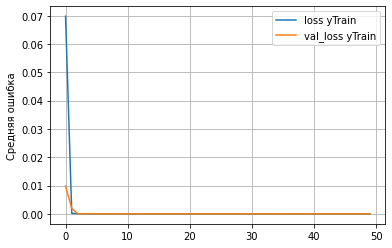

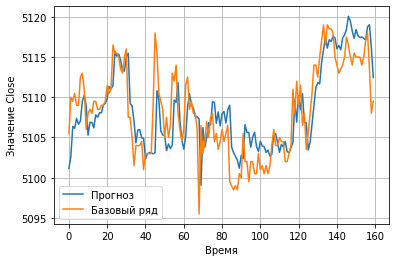

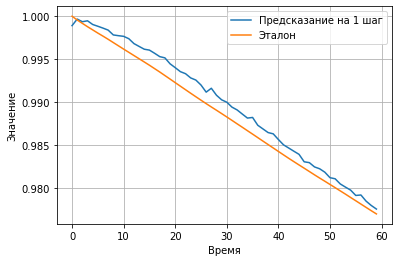

In [ ]:
#Компилируем
model.compile(loss="mse", optimizer=Adam(lr=1e-4))

# коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-05, verbose = 1)
#Checkpoint = ModelCheckpoint('PLZL_Dense___.h5', monitor = 'loss', verbose=1, save_best_only=True)

#Запускаем обучение
history = model.fit_generator(trainDataGen, epochs=50, verbose=1, 
                 validation_data = testDataGen,
                 callbacks = [early_stopping, reduce_lr])


#Выводим графики
plt.plot(history.history['loss'], label='loss yTrain')
plt.plot(history.history['val_loss'], label='val_loss yTrain')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.grid()
plt.show()

#Прогнозируем данные текущей сетью
currModel = model #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные
showPredict(0, 160, 0, predVal, yValUnscaled) #Отображаем графики

#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

# Выводы
------

1. Результат можно добиться сетями разной архитектуры
2. Видимо, сети LSTM вообще хорошо подходят при анализе временных рядов
3. Нужно изучить подробрее принципы работы различных слоев, тк замена Cjnv1D на на его "почти аналог" дала положительный результат. А значит, нужно расширять кругозор и нарабатывать опыт применения разных слоев, нормализаторов и тд и тп.